#Imports

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
import matplotlib.cm as cm

#scvi-tools

In [ ]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

     |████████████████████████████████| 204kB 5.2MB/s 
     |████████████████████████████████| 133kB 9.5MB/s 
     |████████████████████████████████| 81kB 5.9MB/s 
     |████████████████████████████████| 204kB 8.3MB/s 
     |████████████████████████████████| 849kB 9.9MB/s 
     |████████████████████████████████| 634kB 21.2MB/s 
     |████████████████████████████████| 245kB 26.1MB/s 
     |████████████████████████████████| 10.3MB 19.4MB/s 
     |████████████████████████████████| 1.4MB 43.5MB/s 
     |████████████████████████████████| 3.2MB 34.2MB/s 
     |████████████████████████████████| 8.8MB 37.3MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 829kB 30.9MB/s 
     |████████████████████████████████| 184kB 49.3MB/s 
     |████████████████████████████████| 112kB 46.7MB/s 
     |████████████████████████████████| 276kB 47.1MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
   

In [ ]:
import scvi
import scanpy as sc
sc.set_figure_params(figsize=(4, 4))

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


## Loading and preparing data

In [ ]:
!wget https://cf.10xgenomics.com/samples/cell-exp/3.0.2/5k_pbmc_protein_v3/5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5

--2021-05-10 19:13:12--  https://cf.10xgenomics.com/samples/cell-exp/3.0.2/5k_pbmc_protein_v3/5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17129253 (16M) [binary/octet-stream]
Saving to: ‘5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5’

5k_pbmc_protein_v3_ 100%[===================>]  16.33M  32.6MB/s    in 0.5s    

2021-05-10 19:13:13 (32.6 MB/s) - ‘5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5’ saved [17129253/17129253]



In [ ]:
pbmc5k = sc.read_10x_h5(
    "5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5",
    gex_only=False
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [ ]:
pbmc5k.var_names_make_unique()
scvi.data.organize_cite_seq_10x(pbmc5k)

In [ ]:
sc.pp.filter_genes(pbmc5k, min_counts=3)
sc.pp.filter_cells(pbmc5k, min_counts=3)

In [ ]:
pbmc5k.layers["counts"] = pbmc5k.X.copy() # preserve counts
sc.pp.normalize_total(pbmc5k, target_sum=1e4)
sc.pp.log1p(pbmc5k)
pbmc5k.raw = pbmc5k # freeze the state in `.raw`

In [ ]:
sc.pp.highly_variable_genes(
    pbmc5k, 
    n_top_genes=1200, 
    subset=True,
    layer='counts',
    flavor="seurat_v3",
)

In [ ]:
scvi.data.setup_anndata(pbmc5k, protein_expression_obsm_key="protein_expression",layer='counts')

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Using protein expression from adata.obsm['protein_expression']                      
INFO     Using protein names from columns of adata.obsm['protein_expression']                
INFO     Successfully registered anndata object containing 5247 cells, 1200 vars, 1 batches, 
         1 labels, and 32 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


## Creating and training an autoencoder


In [ ]:
model = scvi.model.SCVI(pbmc5k,n_layers=2)

We can see an overview of the model by printing it.

In [ ]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

In [ ]:
model.train(use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [03:06<00:00,  2.14it/s, loss=417, v_num=1]


## Obtaining model outputs

In [ ]:
latent = model.get_latent_representation()

In [ ]:
pbmc5k.obsm["X_scVI"] = latent

## Clustering

Scanpy is a powerful python library for visualization and downstream analysis of scRNA-seq data. We show here how to feed the objects produced by scvi-tools into a scanpy workflow.

In [ ]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(pbmc5k, use_rep="X_scVI")
sc.tl.umap(pbmc5k, min_dist=0.3)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


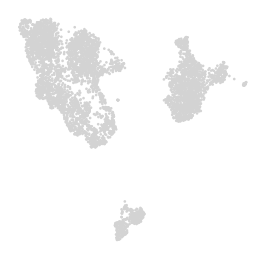

In [ ]:
sc.pl.umap(
    pbmc5k, 
    frameon=False,
)

In [ ]:
# neighbors were already computed using scVI
sc.tl.leiden(pbmc5k, key_added="leiden_scVI", resolution=0.5)

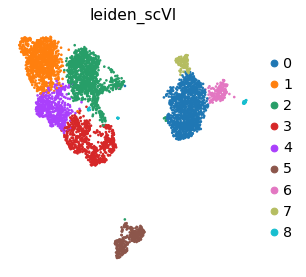

In [ ]:
sc.pl.umap(
    pbmc5k, 
    color=["leiden_scVI"], 
    frameon=False,
)

## Differential expression


In [ ]:
pbmc5k.obs.head()

,n_counts,_scvi_batch,_scvi_labels,_scvi_local_l_mean,_scvi_local_l_var,leiden_scVI
AAACCCAAGAGACAAG-1,7375.0,0,0,5.984777,1.916504,0
AAACCCAAGGCCTAGA-1,3772.0,0,0,5.984777,1.916504,1
AAACCCAGTCGTGCCA-1,4902.0,0,0,5.984777,1.916504,4
AAACCCATCGTGCATA-1,6703.0,0,0,5.984777,1.916504,4
AAACGAAAGACAAGCC-1,3899.0,0,0,5.984777,1.916504,0


For example, a 1-vs-1 DE test is as simple as:

In [ ]:
de_df = model.differential_expression(
    groupby="leiden_scVI", 
    group1="0", 
    group2="2"
)
de_df.head()

DE...: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison
OLFM1,0.9982,0.0018,6.318161,0.000143,2.730150e-06,7.892034,8.190506,2.828830,-2.449751,15.929714,0.032285,0.000966,0.020695,0.000966,0.133802,0.037304,True,0 vs 2
GRAP2,0.9954,0.0046,5.377086,0.000069,1.456531e-03,-4.389474,-4.477363,1.553617,-9.228841,2.563038,0.020695,0.090821,0.017384,0.079227,0.114087,16.027441,True,0 vs 2
LINC02345,0.9954,0.0046,5.377086,0.000004,1.620135e-07,6.270376,6.335911,2.618710,-3.877071,14.911848,0.002483,0.000000,0.002483,0.000000,0.007572,0.000000,True,0 vs 2
TUBA4A,0.9952,0.0048,5.334326,0.000452,4.199924e-03,-3.139577,-3.240887,0.974236,-6.265676,1.913394,0.724336,0.312077,0.433775,0.221256,3.572412,45.523003,True,0 vs 2
IL7R,0.9950,0.0050,5.293303,0.000292,1.668562e-02,-6.025013,-6.316150,2.201993,-13.747570,4.292433,0.213576,0.972948,0.079470,0.440580,1.063796,156.539444,True,0 vs 2


We can also do a 1-vs-all DE test, which compares each cell cluster with the rest of the dataset:

In [ ]:
de_df = model.differential_expression(
    groupby="leiden_scVI", 
)
de_df.head()

DE...: 100%|██████████| 9/9 [00:22<00:00,  2.52s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison
S100A12,0.9968,0.0032,5.741396,0.002976,0.000097,6.238759,6.347468,2.395345,-3.730468,13.925783,6.792189,0.071552,0.891556,0.033177,35.488495,1.078383,True,0 vs Rest
S100A8,0.9966,0.0034,5.680571,0.025872,0.000835,5.853334,6.125758,2.011498,-3.746526,12.126350,50.936001,0.680616,0.990066,0.108443,277.065796,7.432236,True,0 vs Rest
ALDH1A1,0.9964,0.0036,5.623212,0.000427,0.000014,6.427249,6.502705,2.305181,-2.646376,14.689964,0.676324,0.005694,0.379967,0.004952,3.392912,0.046130,True,0 vs Rest
S100A9,0.9956,0.0044,5.421739,0.056058,0.001980,5.763159,6.094614,1.793936,-3.448042,11.468615,129.596054,2.380041,0.999172,0.220352,664.566284,20.497807,True,0 vs Rest
PLA2G7,0.9932,0.0068,4.984008,0.000192,0.000014,6.238955,6.507147,2.761024,-2.858695,16.008953,0.381623,0.012874,0.263245,0.009656,1.741238,0.053139,True,0 vs Rest


##Marker Genes identification

In [ ]:
markers = {}
cats = pbmc5k.obs.leiden_scVI.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:3]

In [ ]:
sc.tl.dendrogram(pbmc5k, groupby="leiden_scVI", use_rep="X_scVI")

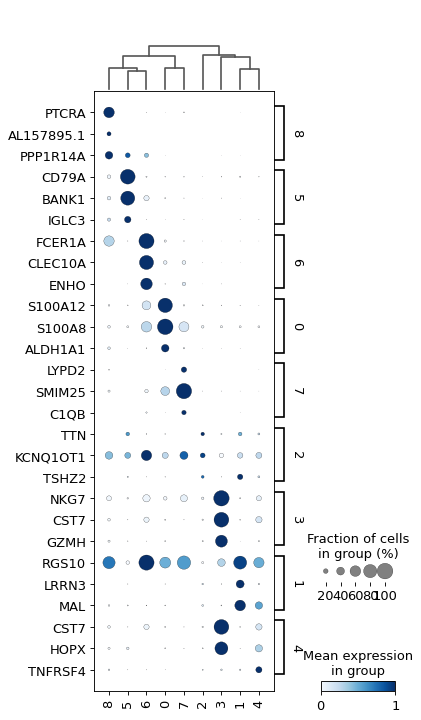

In [ ]:
sc.pl.dotplot(
    pbmc5k, 
    markers, 
    groupby='leiden_scVI', 
    dendrogram=True, 
    color_map="Blues",
    swap_axes=True,
    standard_scale="var",
)

We can also visualize the scVI normalized gene expression values with the `layer` option.

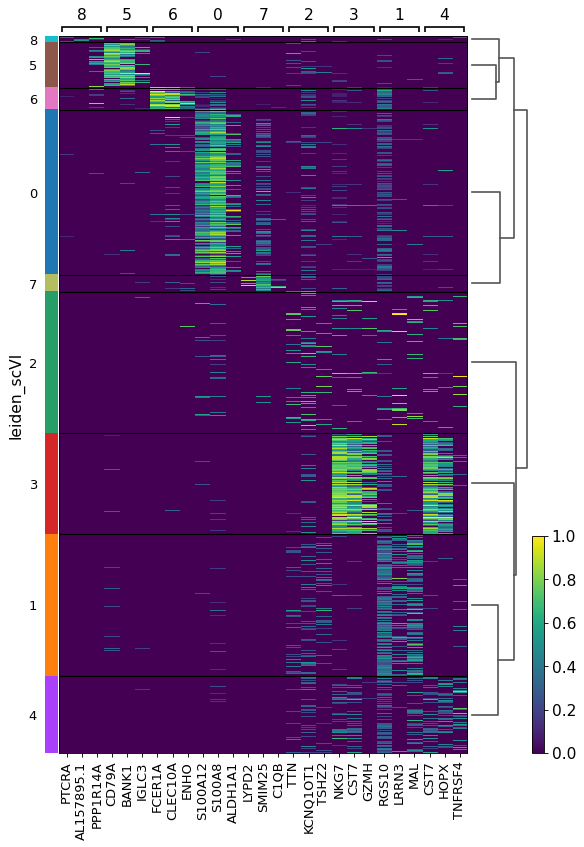

In [ ]:
sc.pl.heatmap(
    pbmc5k, 
    markers, 
    groupby='leiden_scVI', 
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12)
)

##Cluster annotation

#Silhouette Analysis

In [ ]:
import scanpy as sc
adata=sc.datasets.ebi_expression_atlas("E-MTAB-5061",filter_boring=True)
#QC
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)
#normalization
sc.pp.log1p(adata)
#feature selection
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=2000, 
    subset=True,
    flavor="cell_ranger",
)

##Reducing dimension

In [ ]:
adatap=sc.pp.pca(adata,n_comps=1000,copy=True)

Text(0, 0.5, 'Variance Ratio')

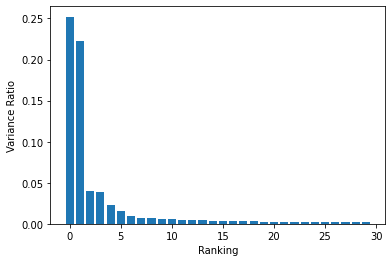

In [ ]:
#Elbow method
import matplotlib.pyplot as plt
_, ax = plt.subplots()
ax.bar(np.arange(30),adatap.uns['pca']['variance_ratio'][:30])
ax.set_xlabel('Ranking')
ax.set_ylabel('Variance Ratio')

In [ ]:
sc.pp.pca(adata,n_comps=6)

##Clustering

For n_clusters = 4 The average silhouette_score is : 0.25774243
For n_clusters = 5 The average silhouette_score is : 0.25984788
For n_clusters = 6 The average silhouette_score is : 0.24898177
For n_clusters = 7 The average silhouette_score is : 0.21518439
For n_clusters = 8 The average silhouette_score is : 0.21692719
For n_clusters = 9 The average silhouette_score is : 0.20611721
For n_clusters = 10 The average silhouette_score is : 0.18409292
For n_clusters = 11 The average silhouette_score is : 0.18527256


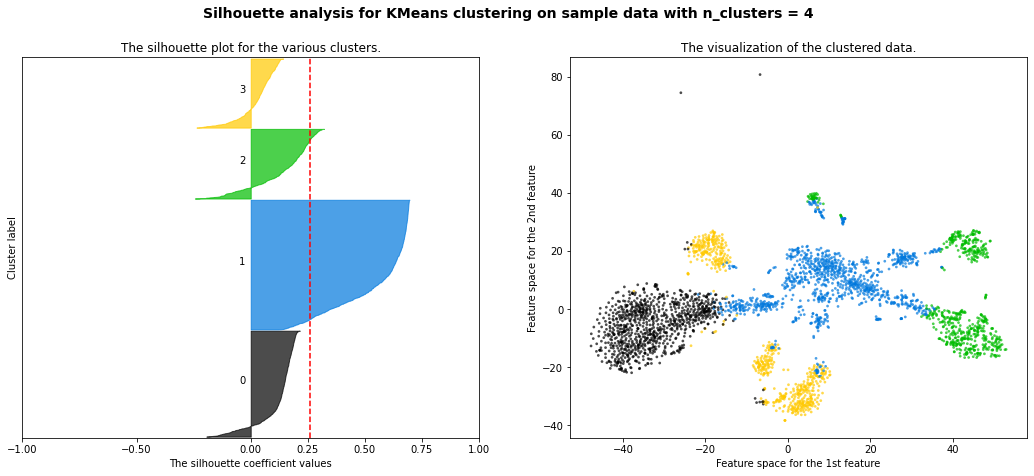

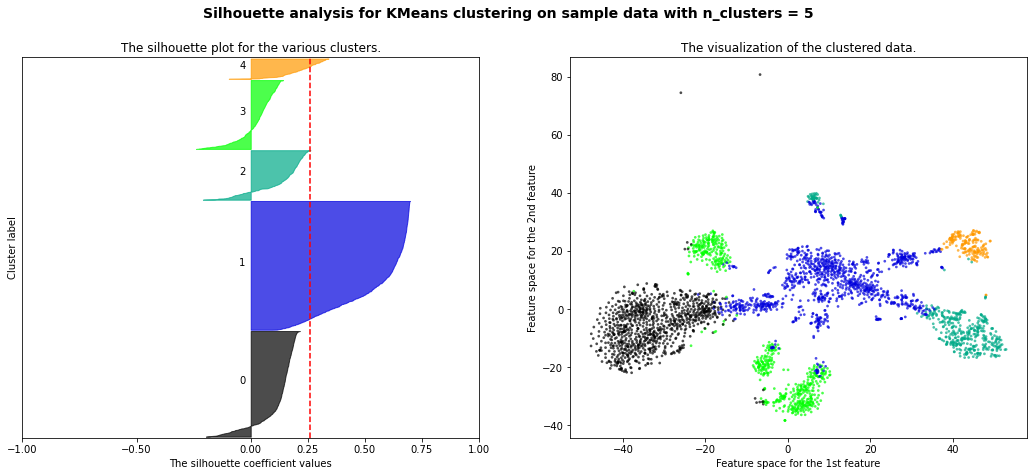

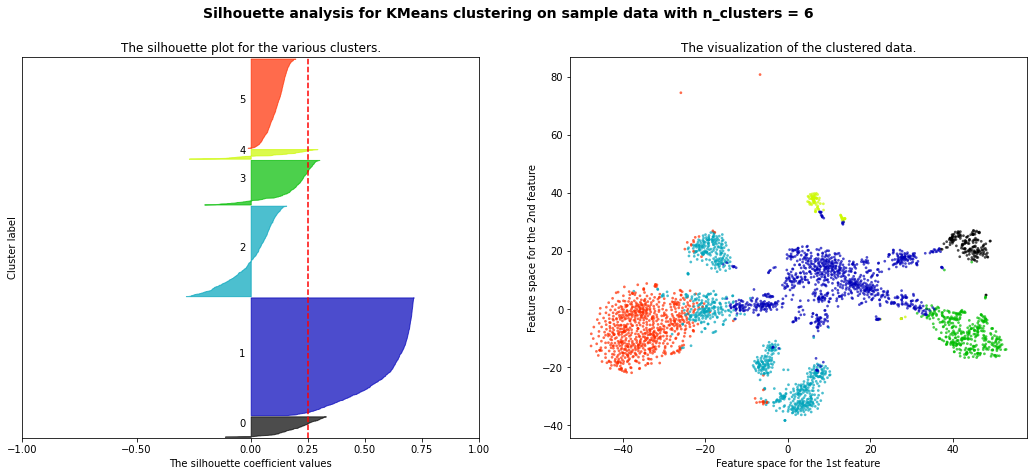

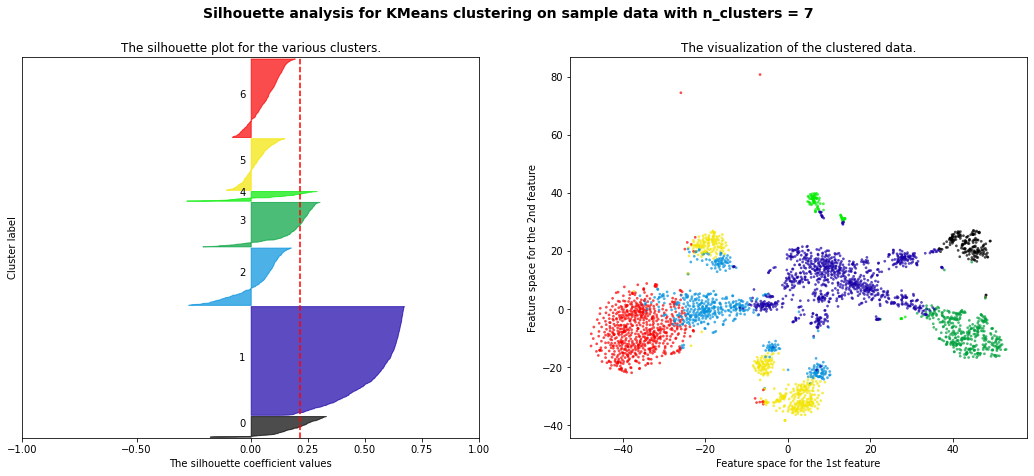

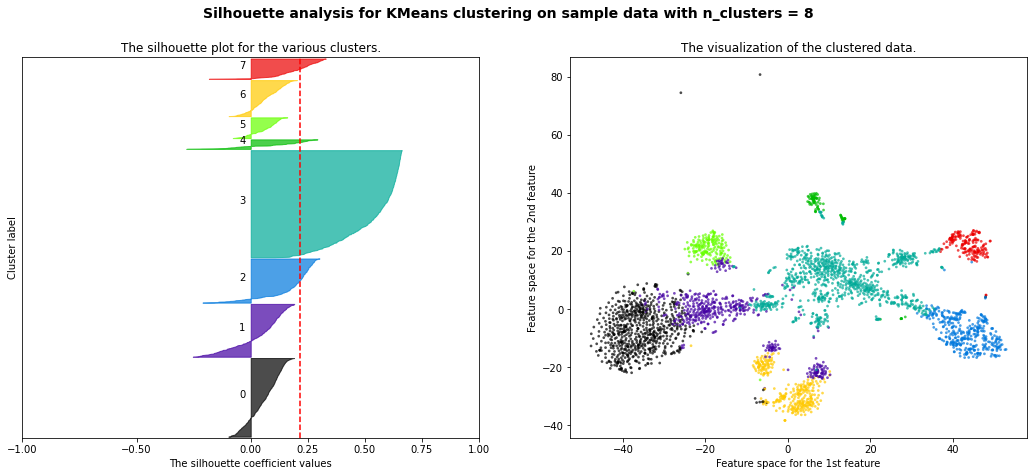

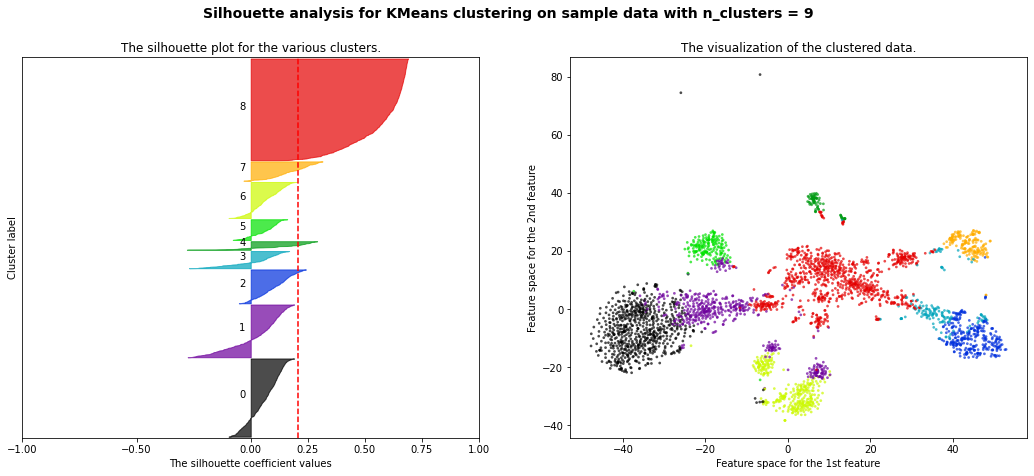

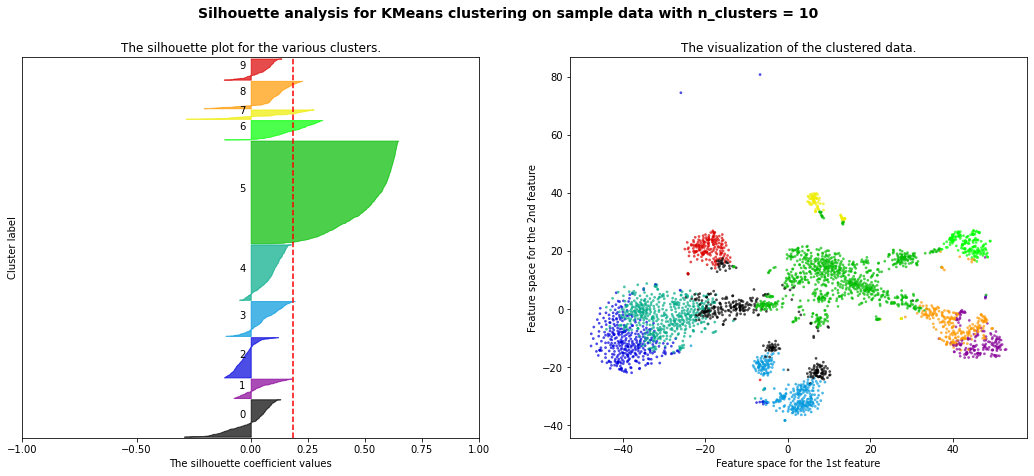

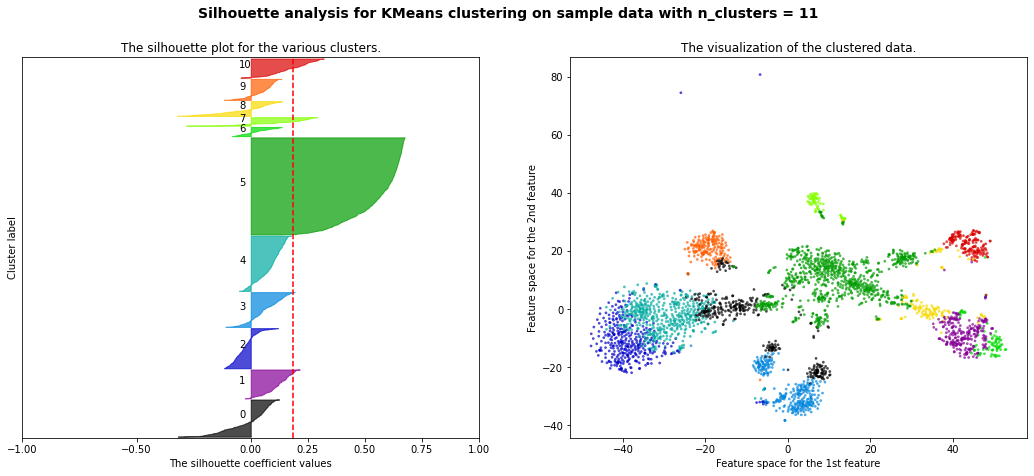

In [ ]:
X=adata.X.toarray()
for n_clusters in [4,5,6,7,8,9,10,11]:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.5, 0, 0.25, 0.5, 0.75, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    Xp=TSNE(random_state=10).fit_transform(X)
    ax2.scatter(Xp[:, 0], Xp[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

# Further Reading
[Current best practices in single‐cell RNA‐seq analysis: a tutorial](https://www.researchgate.net/publication/333883979_Current_best_practices_in_single-cell_RNA-seq_analysis_a_tutorial)

#References

1.Current best practices in single-cell RNA-seqanalysis: a tutorial Luecken et al.

2.https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

3.https://docs.scvi-tools.org/en/stable/user_guide/notebooks